# Keras Tuner: Reuters Dataset

Código base: Santiago Hernández

## Conjunto de datos

Este es un conjunto de datos de 11.228 noticias de Reuters, etiquetadas en 46 temas.

Esto fue originalmente generado por el análisis y preprocesamiento del clásico conjunto de datos de Reuters-21578, pero el código de preprocesamiento ya no está empaquetado con Keras. 

Cada noticia está codificado como una lista de índices de palabras (números enteros). Para mayor comodidad, las palabras se indexan por la frecuencia general en el conjunto de datos, de modo que, por ejemplo, el número entero "3" codifica la tercera palabra más frecuente en los datos. Esto permite realizar operaciones de filtrado rápido como: "considerar sólo las 10.000 palabras más comunes, pero eliminar las 20 palabras más comunes".

## 1. Cargando el conjunto de datos

In [2]:
from tensorflow.keras.datasets import reuters

In [3]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2121728/2110848 [==============================] - 1s 0us/step


## Preprocesamiento del conjunto de datos

A pesar de que ya tenemos codificadas las reseñas para que esten representadas por valores numéricos en lugar de por cadenas de texto, existen algunos factores que no permiten que sean conjuntos de datos apropiados para proporcionarle a una red neuronal artifical.

In [4]:
import numpy as np

def vectorize(seqs, dim=10000):
    results = np.zeros((len(seqs), dim))
    for i, seq in enumerate(seqs):
        results[i, seq] = 1.
    return results

Vectorizamos tanto el conjunto de datos de entrenamiento, como el conjunto de datos de pruebas.

In [5]:
# Vectorizamos el conjunto de datos de entrenamiento y el de pruebas
X_train = vectorize(train_data, 10000)
X_test = vectorize(test_data, 10000)

In [6]:
# Cada una de las reseñas se corresponde con un vector formado por 1s y 0s
print("Valores originales:\t", train_data[0][:15])
print("Valores vectorizados:\t", X_train[0][:15])

Valores originales:	 [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16]
Valores vectorizados:	 [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


In [7]:
# Transformamos las etiquetas de salida en vectores
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(train_labels)
Y_test = to_categorical(test_labels)

## División del conjunto de datos 

In [8]:
from sklearn.model_selection import train_test_split

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

In [9]:
print("Longitud subconjunto de entrenamiento: ", len(X_train))
print("Longitud subconjunto de validación: ", len(X_val))
print("Longitud subconjunto de pruebas: ", len(X_test))

Longitud subconjunto de entrenamiento:  8982
Longitud subconjunto de validación:  1123
Longitud subconjunto de pruebas:  1123


## Construcción de la red neuronal artificial

### Función para la realización del tuning

In [12]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import keras_tuner as kt

# TP5 - En la siguiente celda complete según se le indica en comentarios

In [15]:
def model_builder(hp):
    
    # Defina un modello secuencial
    # COMPLETAR
    
    model = keras.Sequential()
    
    # Tuning del número de neuronas de las hidden layer
    # Entre 16 y 128, en steps de 16
    # COMPLETAR
 
    hp_units = hp.Int('units', min_value = 16, max_value = 128, step = 16) 

    # Tuning del número de capas
    # Entre 1 y 5, con steps de 2
    # COMPLETAR
    
    hp_layers = hp.Int('layers', min_value = 1, max_value = 5, step = 2)
    
    # Input layer
    model.add(layers.Dense(units=128, activation='relu', input_shape=(10000,)))
    
    # Hidden layers 
    for i in range(hp_layers):
        # Añadimos la hidden layer
        model.add(layers.Dense(units=hp_units, activation='relu'))
        
    # Output layer
    model.add(layers.Dense(46, activation='softmax'))
    
    # Varios learning rate, valores [0.01, 0.001, 0.0001]
    # COMPLETAR
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Completar el model.compile
    # el optimizador es keras.optimizers.Adam, variando los diferentes learning rate definidos
    # de loss usar 'categorical_crossentropy'
    # de métrica usar "accuracy"
    # model.compile(
        # COMPLETAR
    # )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [16]:
tuner = kt.Hyperband(
    model_builder,
    objective= 'val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hp_dir',
    project_name='ruters_dataset'
)

In [17]:
# Creamos una función de callback que limpie el output
import IPython
import tensorflow as tf

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [18]:
# Ejecución del proceso de tuning
tuner.search(
    X_train, 
    Y_train,
    epochs=10,
    validation_data=(X_val, Y_val),
    callbacks=[ClearTrainingOutput()]
)

Trial 30 Complete [00h 00m 15s]
val_accuracy: 0.7845057845115662

Best val_accuracy So Far: 0.8103294968605042
Total elapsed time: 00h 03m 51s
INFO:tensorflow:Oracle triggered exit


In [19]:
# Obtención de los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hps.get('units'))
print("Layers:", best_hps.get('layers'))

Units: 80
Layers: 1


In [20]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train,
    Y_train,
    epochs = 20,
    validation_data = (X_val, Y_val)
)

Epoch 1/20
281/281 [==============================] - 2s 6ms/step - loss: 1.3574 - accuracy: 0.7116 - val_loss: 0.9425 - val_accuracy: 0.7818
Epoch 2/20
281/281 [==============================] - 2s 6ms/step - loss: 0.5032 - accuracy: 0.8891 - val_loss: 0.8972 - val_accuracy: 0.7934
Epoch 3/20
281/281 [==============================] - 2s 6ms/step - loss: 0.2749 - accuracy: 0.9377 - val_loss: 0.9313 - val_accuracy: 0.7996
Epoch 4/20
281/281 [==============================] - 2s 6ms/step - loss: 0.2032 - accuracy: 0.9482 - val_loss: 1.0255 - val_accuracy: 0.7925
Epoch 5/20
281/281 [==============================] - 2s 6ms/step - loss: 0.1760 - accuracy: 0.9496 - val_loss: 0.9932 - val_accuracy: 0.8085
Epoch 6/20
281/281 [==============================] - 2s 6ms/step - loss: 0.1579 - accuracy: 0.9500 - val_loss: 1.0043 - val_accuracy: 0.8041
Epoch 7/20
281/281 [==============================] - 2s 6ms/step - loss: 0.1423 - accuracy: 0.9512 - val_loss: 1.0252 - val_accuracy: 0.8085
Epoch 

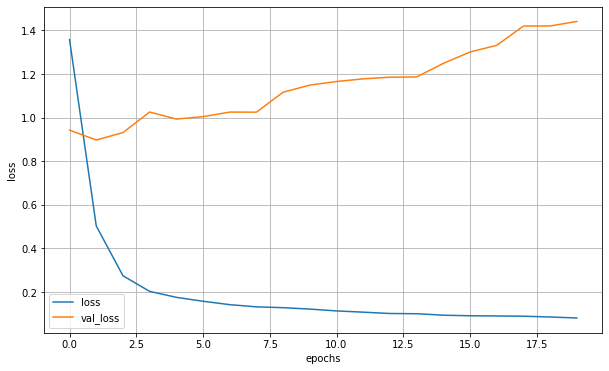

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

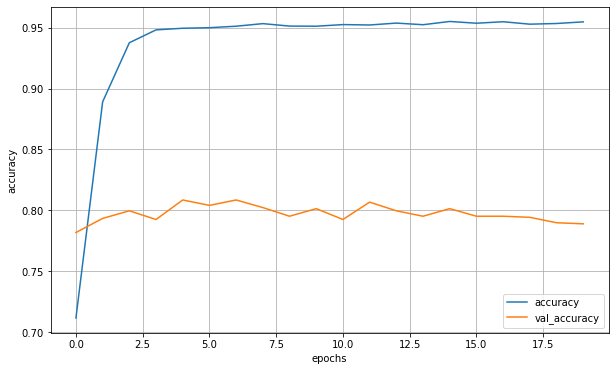

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [23]:
model.evaluate(X_test, Y_test)

36/36 [==============================] - 0s 1ms/step - loss: 1.3663 - accuracy: 0.7934


[1.3662846088409424, 0.7934104800224304]

In [24]:
model.predict(X_test).round(0)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# TP5 - En la siguiente celda de texto comente los resultados obtenidos del experimento

 Completar aquí
 